# Package

In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_sup_dataset import load_train_test

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = load_train_test()

>> Loading the trainset
Total images are 93408


>> Loading the testset
Total images are 98904




In [6]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = False, num_workers = 4)
len(trainloader), len(valloader)

(730, 773)

torch.Size([128, 3, 224, 224]) torch.Size([128])


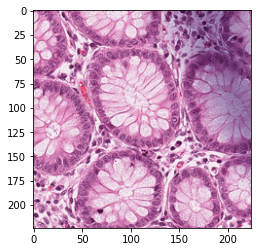

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Dual Attention - backbone resnet18

In [7]:
from trainer.dualattention_trainer import DualAttentionTrainer

run_on = "CRC_DX"

In [8]:
dualattention_trainer = DualAttentionTrainer(trainloader, valloader, num_cycle = 8, valset = valset, netname = "ResNet_DualAttention")
max_epochs = dualattention_trainer.get_max_epochs()

In [9]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "dualattention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/CRC_DX'

In [10]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "dualattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning rate finder

In [12]:
lr_finder = trainer.lr_find(dualattention_trainer)

>> Reset the optimizer


INFO:lightning:
   | Name                                       | Type                  | Params
---------------------------------------------------------------------------------
0  | criterion                                  | BCEWithLogitsLoss     | 0     
1  | model                                      | DualAttentionModel    | 12 M  
2  | model.model                                | Sequential            | 11 M  
3  | model.model.0                              | Conv2d                | 9 K   
4  | model.model.1                              | BatchNorm2d           | 128   
5  | model.model.2                              | ReLU                  | 0     
6  | model.model.3                              | MaxPool2d             | 0     
7  | model.model.4                              | Sequential            | 147 K 
8  | model.model.4.0                            | BasicBlock            | 73 K  
9  | model.model.4.0.conv1                      | Conv2d                | 36 K  
10 | model.

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...
INFO:lightning:LR finder stopped early due to diverging loss.


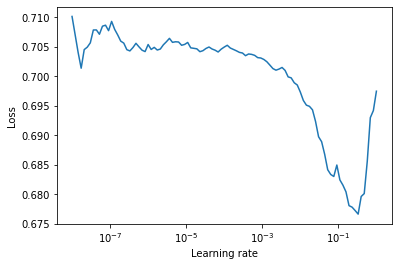

In [13]:
fig = lr_finder.plot(suggest = True)

In [11]:
dualattention_trainer.base_lr = 8e-5
dualattention_trainer.max_lr = 9e-2
dualattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.0036
    lr: 0.003600000000000006
    max_lr: 0.09
    max_momentum: 0.95
    min_lr: 3.6e-07
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

## Train the model

In [ ]:
trainer.fit(dualattention_trainer)

INFO:lightning:
   | Name                                       | Type                  | Params
---------------------------------------------------------------------------------
0  | criterion                                  | BCEWithLogitsLoss     | 0     
1  | model                                      | DualAttentionModel    | 12 M  
2  | model.model                                | Sequential            | 11 M  
3  | model.model.0                              | Conv2d                | 9 K   
4  | model.model.1                              | BatchNorm2d           | 128   
5  | model.model.2                              | ReLU                  | 0     
6  | model.model.3                              | MaxPool2d             | 0     
7  | model.model.4                              | Sequential            | 147 K 
8  | model.model.4.0                            | BasicBlock            | 73 K  
9  | model.model.4.0.conv1                      | Conv2d                | 36 K  
10 | model.

>> Reset the optimizer


INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_0_v1.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_1_v1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_2_v1.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_3_v1.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_4_v1.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_5_v1.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/dualattention/_ckpt_epoch_6_v1.ckpt
